In [ ]:
#https://medium.com/diving-in-deep/facial-keypoints-detection-with-pytorch-86bac79141e4


In [54]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models

In [35]:
data_dir = Path('./Facial_Keypoints_Detection_Kaggle')
train_data = pd.read_csv(data_dir/'training.csv')
train_data.T

,0,1,2,3,4,5,6,7,8,9,...,7039,7040,7041,7042,7043,7044,7045,7046,7047,7048
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253,69.6807,64.1319,67.4689,65.8029,64.1212,...,69.2299,63.353,65.7112,67.9293,66.8672,67.4025,66.1344,66.6907,70.9651,66.9383
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213,39.9687,34.29,39.4135,34.7552,36.7403,...,38.5756,35.6713,38.8435,35.8466,37.3569,31.8426,38.3655,36.8452,39.8537,43.4245
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448,29.1836,29.579,29.356,27.4758,29.4689,...,29.4079,33.9521,32.2688,28.6878,30.7509,29.7467,30.4786,31.6664,30.5433,31.0961
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042,37.5634,33.138,39.6217,36.1856,38.3902,...,38.3455,40.8164,37.706,41.4525,40.1157,38.6329,39.9502,39.685,40.7723,39.5286
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659,62.8643,57.7972,59.555,58.6522,58.6209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213,40.1693,35.154,40.4548,37.3293,37.8406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159,76.8982,69.0266,75.5916,72.953,71.272,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845,41.1719,34.29,40.0382,35.8995,37.2903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824,36.401,34.7617,37.4782,36.3424,36.3446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949,39.3676,33.714,40.4548,37.0432,39.4905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
IMG_SIZE = 96 # image size 96 x 96 pixels

def show_keypoints(image, keypoints):
    '''
    Show image with keypoints
    Args:
        image (array-like or PIL image): The image data. (M, N)
        keypoints (array-like): The keypoits data. (N, 2)
    '''
      
    plt.imshow(image, cmap='gray')
    if len(keypoints):
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=24, marker ='.', c='r')
        
def show_images(df, indxs, ncols=5, figsize=(15,10), with_keypoints=True):
    '''
    Show images with keypoints in grids
    Args:
        df (DataFrame): data (M x N)
        idxs (iterators): list, Range, Indexes
        ncols (integer): number of columns (images by rows)
        figsize (float, float): width, height in inches
        with_keypoints (boolean): True if show image with keypoints
    '''
    plt.figure(figsize=figsize)
    nrows = len(indxs) // ncols + 1
    for i, idx in enumerate(indxs):
        image = np.fromstring(df.loc[idx, 'Image'], sep=' ').astype(np.float32)\
                .reshape(-1, IMG_SIZE)
        if with_keypoints:
            keypoints = df.loc[idx].drop('Image').values.astype(np.float32)\
                        .reshape(-1, 2)
        else:
            keypoints = []
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f'Sample #{idx}')
        plt.axis('off')
        plt.tight_layout()
        show_keypoints(image, keypoints)
    plt.show()

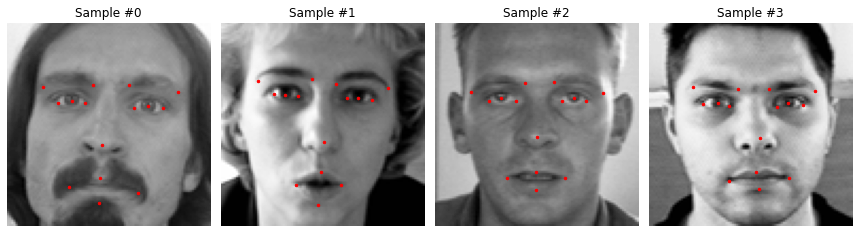

In [25]:
show_images(train_data, range(4))

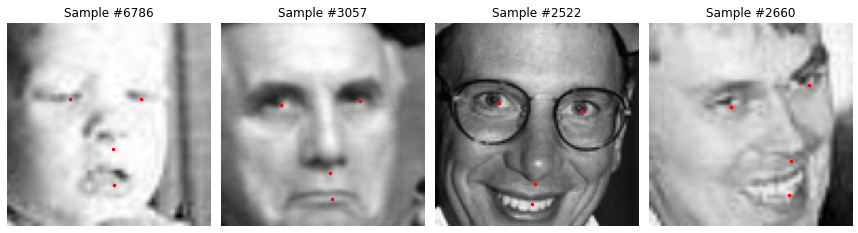

In [33]:
missing_any_data = train_data[train_data.isnull().any(axis=1)]
idxs = np.random.choice(missing_any_data.index, 4)
show_images(train_data, idxs)

In [48]:
test_data = pd.read_csv(data_dir / 'test.csv')
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [49]:
train_df = train_data.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140 entries, 0 to 2283
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [63]:
class FaceKeypointsDataset(Dataset):
    '''Face Keypoints Dataset'''
    def __init__(self, dataframe, train=True, transform=None):
        '''
        Args:
            dataframe (DataFrame): data in pandas dataframe format.
            train (Boolean) : True for train data with keypoints, default is True
            transform (callable, optional): Optional transform to be applied on 
            sample
        '''
        self.dataframe = dataframe
        self.train = train
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = np.fromstring(self.dataframe.iloc[idx, -1], sep=' ')\
                .astype(np.float32).reshape(-1, IMG_SIZE)
        if self.train:
            keypoints = self.dataframe.iloc[idx, :-1].values.astype(np.float32)
        else:
            keypoints = None
        sample = {'image': image, 'keypoints': keypoints}
        if self.transform:
            sample = self.transform(sample)
        return sample
    

class Normalize(object):
    '''Normalize input images'''
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        return {'image': image / 255., # scale to [0, 1]
                'keypoints': keypoints}
        
class ToTensor(object):
    '''Convert ndarrays in sample to Tensors.'''
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        image = torch.from_numpy(image)
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}
        
class RandomHorizontalFlip(object):
    '''
    Horizontally flip image randomly with given probability
    Args:
        p (float): probability of the image being flipped.
                   Defalut value = 0.5
    '''
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        
        flip_indices = [(0, 2), (1, 3),
                        (4, 8), (5, 9), (6, 10), (7, 11),
                        (12, 16), (13, 17), (14, 18), (15, 19),
                        (22, 24), (23, 25)]
        image, keypoints = sample['image'], sample['keypoints']
        if np.random.random() < self.p:
            image = image[:, ::-1]
            if keypoints is not None:
                for a, b in flip_iimport torch.nn as nn
from torch import optim
import torch.nn.functional as Fndices:
                    keypoints[a], keypoints[b]= keypoints[b], keypoints[a]
                keypoints[::2] = 96. - keypoints[::2]
        return {'image': image, 
                'keypoints': keypoints}


In [64]:
from torch.utils.data.sampler import SubsetRandomSampler

def prepare_train_valid_loaders(trainset, valid_size=0.2, 
                                batch_size=128):
    '''
    Split trainset data and prepare DataLoader for training and validation
    
    Args:
        trainset (Dataset): data 
        valid_size (float): validation size, defalut=0.2
        batch_size (int) : batch size, default=128
    ''' 
    
    # obtain training indices that will be used for validation
    num_train = len(trainset)
    indices = import torch.nn as nn
from torch import optim
import torch.nn.functional as Flist(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=valid_sampler)
    
    return train_loader, valid_loader

In [65]:
from torchvision import transforms

# drop any-missing-keypoint records
train_df = train_data.dropna()
test_df = test_data

# how many samples per batch to load
batch_size = 128
# percentage of training set to use as validation
valid_size = 0.2

# Define a transform to normalize the data
tsfm = transforms.Compose([RandomHorizontalFlip(p=0.5), Normalize(), ToTensor()])

# Load the training data and test data
trainset = FaceKeypointsDataset(train_df, transform=tsfm)
testset = FaceKeypointsDataset(test_df, train=False, transform=tsfm)

# prepare data loaders
train_loader, valid_loader = prepare_train_valid_loaders(trainset, 
                                                         valid_size,
                                                         batch_size)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [75]:
class CNN(nn.Module):
    '''
    Convolutional Neural Network model
            
    Args:
        ---------
        output_size (integer): size of the output layer
    '''
    
    def __init__(self, outputs=30):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*12*12, 1024)
        self.fc2 = nn.Linear(1024, outputs)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        
        return x

In [77]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50, saved_model='model.pt'):
    '''
    Train the model
    
    Args:
        train_loader (DataLoader): DataLoader for train Dataset
        valid_loader (DataLoader): DataLoader for valid Dataset
        model (nn.Module): model to be trained on
        criterion (torch.nn): loss funtion
        optimizer (torch.optim): optimization algorithms
        n_epochs (int): number of epochs to train the model
        saved_model (str): file path for saving model
    
    Return:
        tuple of train_losses, valid_losses
    '''

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*batch['image'].size(0)

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # update running validation loss 
            valid_loss += loss.item()*batch['image'].size(0)

        # print training/validation statistics 
        # calculate average Root Mean Square loss over an epoch
        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses 

In [76]:
model = CNN(outputs=30)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [78]:
train(train_loader, valid_loader, model, criterion,  
optimizer, n_epochs=50, saved_model='aug_cnn.pt')

Epoch: 1 	Training Loss: 24.593333 	Validation Loss: 8.722365
Validation loss decreased (inf --> 8.722365).  Saving model ...
Epoch: 2 	Training Loss: 7.498123 	Validation Loss: 5.215322
Validation loss decreased (8.722365 --> 5.215322).  Saving model ...
Epoch: 3 	Training Loss: 5.019913 	Validation Loss: 3.783719
Validation loss decreased (5.215322 --> 3.783719).  Saving model ...
Epoch: 4 	Training Loss: 4.158746 	Validation Loss: 3.515807
Validation loss decreased (3.783719 --> 3.515807).  Saving model ...
Epoch: 5 	Training Loss: 4.053044 	Validation Loss: 3.730839
Epoch: 6 	Training Loss: 4.188015 	Validation Loss: 3.771712
Epoch: 7 	Training Loss: 4.157804 	Validation Loss: 3.487388
Validation loss decreased (3.515807 --> 3.487388).  Saving model ...
Epoch: 8 	Training Loss: 3.913416 	Validation Loss: 3.405463
Validation loss decreased (3.487388 --> 3.405463).  Saving model ...
Epoch: 9 	Training Loss: 3.863379 	Validation Loss: 3.268291
Validation loss decreased (3.405463 --> 3

([24.5933332484598,
  7.498122879374413,
  5.019912861587145,
  4.158746476357492,
  4.053043854654131,
  4.188014794450779,
  4.15780432917348,
  3.913416043469714,
  3.8633794524685903,
  3.8583249238241364,
  3.8566556600310293,
  3.826136529054049,
  3.8381322858976064,
  3.944439344801887,
  3.7549120725878287,
  3.7256081992929557,
  3.701744287613574,
  3.735457533925304,
  3.8526411130458964,
  3.7183088710409273,
  3.6793008340743145,
  3.6665231116991484,
  4.121615524975869,
  3.6457694436057686,
  3.762664838546124,
  3.72444213798633,
  3.6187588192161426,
  3.7086324556779102,
  3.7909797714113096,
  3.8493549612658233,
  4.03413715320751,
  3.7781554942418576,
  3.726056716597506,
  3.5892063315263325,
  3.4762877495429008,
  3.492038938272717,
  3.679111133634283,
  3.476756486785264,
  3.5828977512310294,
  3.6439350386886997,
  3.4828900669089076,
  3.566027692107787,
  3.4582314970422114,
  3.507782052798472,
  3.401427108306981,
  3.5256069552594056,
  3.42442143874

In [88]:

def predict(data_loader, model):
    '''
    Predict keypoints
    Args:
        data_loader (DataLoader): DataLoader for Dataset
        model (nn.Module): trained model for prediction.
    Return:
        predictions (array-like): keypoints in float (no. of images x keypoints).
    '''
    
    model.eval() # prep model for evaluation

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))
    
    return predictions

def view_pred_df(columns, test_df, predictions, image_ids=range(1,6)):
    '''
    Display predicted keypoints
    Args:
        columns (array-like): column names
        test_df (DataFrame): dataframe with ImageId and Image columns
        predictions (array-like): keypoints in float (no. of images x keypoints)
        image_id (array-like): list or range of ImageIds begin at 1
    '''
    pred_df = pd.DataFrame(predictions, columns=columns)
    pred_df = pd.concat([pred_df, test_df], axis=1)
    pred_df = pred_df.set_index('ImageId')
    show_images(pred_df, image_ids)  # ImageId as index begin at 1

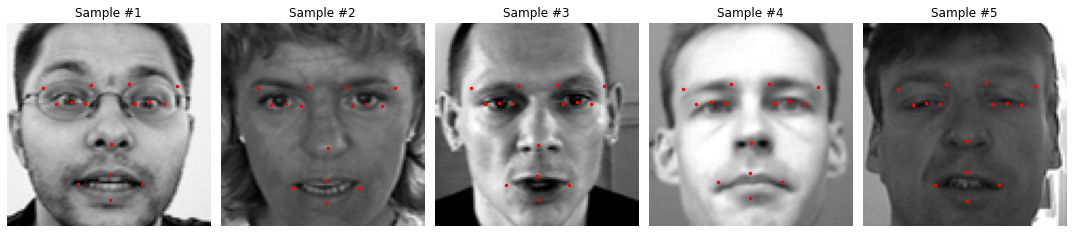

In [92]:
model.load_state_dict(torch.load('aug_cnn.pt'))
predictions = predict(test_loader, model)
columns = train_df.drop('Image', axis=1).columns
view_pred_df(columns, test_df, predictions)